# Symbolic Music Tokenizers

This notebook shows how symbolic music tokenizers can be used to convert symbolic music data (like MIDI files) into token sequences suitable for machine learning models, and vice versa.

For MIDI, we will use the `MIDITok` library, while for MusicXML, we will use the `linearize-musicxml` library.

In [19]:
import sys
from glob import glob
from pathlib import Path
from xml.etree import ElementTree as ET

import matplotlib.pyplot as plt
import pypianoroll
from lmx.linearization.Linearizer import Linearizer
from miditok import REMI, MIDILike, Structured, TokenizerConfig

In [20]:
# define paths
DATA_PATH = Path("../data")
MIDI_PATH = DATA_PATH / "midi"
MUSICXML_PATH = DATA_PATH / "musicxml"
ABC_PATH = DATA_PATH / "abc"

# create lists of files
midi_files = sorted(glob(str(MIDI_PATH / "*.mid")))
musicxml_files = sorted(
    glob(str(MUSICXML_PATH / "*.musicxml"))
)  # in the same folder you can find .musicxml files too (non-compressed)
abc_files = sorted(glob(str(ABC_PATH / "*.abc")))
print(
    f"Found {len(midi_files)} MIDI files."
    f"\nFound {len(musicxml_files)} MusicXML files."
    f"\nFound {len(abc_files)} ABC files."
)

Found 100 MIDI files.
Found 100 MusicXML files.
Found 100 ABC files.


## MIDITok Tokenizers

MIDITok provides several tokenization strategies for MIDI files, including REMI, TSD, and CPWord. Here, we will demonstrate how to use the REMI tokenizer and explore different configurations.

First, let's explore an example MIDI file we will use for tokenization:



In [21]:
import pretty_midi as pm

# get the number of instruments in the first MIDI file
midi_data = pm.PrettyMIDI(midi_files[1])
num_instruments = len(midi_data.instruments)
print(f"Number of instruments in the first MIDI file: {num_instruments}")

Number of instruments in the first MIDI file: 9


Let's test a basic configuration. If `use_programs` is set to `False` (default), each instrument will have its own token stream. 

In [22]:
# Our parameters
TOKENIZER_PARAMS = {
    "pitch_range": (21, 109),
    "beat_res": {(0, 4): 8, (4, 512): 4},  # resolution changes based on beat position
    "num_velocities": 32,
    "special_tokens": ["PAD", "BOS", "EOS", "MASK"],  # "PAD" token is always added
    "use_chords": False,
    "use_rests": False,
    "use_tempos": True,
    "use_time_signatures": False,
    "use_programs": False,
    "one_token_stream_for_programs": False,  # to use if use_programs is True
    "num_tempos": 32,  # number of tempo bins
    "tempo_range": (40, 250),  # (min, max)
}
config = TokenizerConfig(**TOKENIZER_PARAMS)

# Tokenize using REMI
remi_tokenizer = REMI(tokenizer_config=config)
remi_tokens = remi_tokenizer(midi_files[1])
print(f"Number of token streams (instruments): {len(remi_tokens)}\n")

# If there are multiple instruments, print the length of each token stream
if isinstance(remi_tokens, list):
    for i, tokens in enumerate(remi_tokens):
        print(f"Instrument {i + 1} tokenized sequence length: {len(tokens)}")

# inspect the first 10 tokens of the first instrument
print(f"\nFirst 10 REMI tokens of the first instrument:\n {remi_tokens[0][:10]}")  # type: ignore


Number of token streams (instruments): 9

Instrument 1 tokenized sequence length: 2780
Instrument 2 tokenized sequence length: 904
Instrument 3 tokenized sequence length: 704
Instrument 4 tokenized sequence length: 832
Instrument 5 tokenized sequence length: 396
Instrument 6 tokenized sequence length: 3332
Instrument 7 tokenized sequence length: 1549
Instrument 8 tokenized sequence length: 396
Instrument 9 tokenized sequence length: 5670

First 10 REMI tokens of the first instrument:
 TokSequence(tokens=['Bar_None', 'Position_0', 'Tempo_94.19', 'Position_28', 'Pitch_33', 'Velocity_111', 'Duration_0.4.8', 'Bar_None', 'Position_0', 'Pitch_34'], ids=[4, 2190, 2292, 2218, 17, 121, 129, 4, 2190, 18], bytes='', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Tempo, value=94.19, time=0, desc=94.19004411233733), Event(type=Position, value=28, time=28, desc=28), Event(type=Pitch, value=33, time=28, desc=32), Event(type=Velocity, val

If we also consider rests and chords, the number of tokens will change accordingly.

In [23]:
# use the old configuration but override the `use_chords` and `use_rests` parameters
TOKENIZER_PARAMS["use_chords"] = False
TOKENIZER_PARAMS["use_rests"] = True

config_with_chords_rests = TokenizerConfig(
    **TOKENIZER_PARAMS,
)
remi_tokenizer_chords_rests = REMI(tokenizer_config=config_with_chords_rests)
remi_tokens_chords_rests = remi_tokenizer_chords_rests(midi_files[1])
print(
    f"\nNumber of token streams (instruments) with chords and rests: {len(remi_tokens_chords_rests)}\n"
)

# If there are multiple instruments, print the length of each token stream
if isinstance(remi_tokens_chords_rests, list):
    for i, tokens in enumerate(remi_tokens_chords_rests):
        print(
            f"Instrument {i + 1} tokenized sequence length with chords and rests: {len(tokens)}"
        )


# inspect the first 10 tokens of the first instrument
print(
    f"\nFirst 10 REMI tokens of the first instrument with chords and rests:\n {remi_tokens_chords_rests[0][:10]}"  # type: ignore
)


Number of token streams (instruments) with chords and rests: 9

Instrument 1 tokenized sequence length with chords and rests: 2783
Instrument 2 tokenized sequence length with chords and rests: 880
Instrument 3 tokenized sequence length with chords and rests: 674
Instrument 4 tokenized sequence length with chords and rests: 822
Instrument 5 tokenized sequence length with chords and rests: 382
Instrument 6 tokenized sequence length with chords and rests: 3347
Instrument 7 tokenized sequence length with chords and rests: 1517
Instrument 8 tokenized sequence length with chords and rests: 382
Instrument 9 tokenized sequence length with chords and rests: 6428

First 10 REMI tokens of the first instrument with chords and rests:
 TokSequence(tokens=['Bar_None', 'Position_0', 'Tempo_94.19', 'Rest_3.1.2', 'Position_28', 'Pitch_33', 'Velocity_111', 'Duration_0.4.8', 'Bar_None', 'Position_0'], ids=[4, 2190, 2324, 2298, 2218, 17, 121, 129, 4, 2190], bytes='', events=[Event(type=Bar, value=None, ti

If `use_programs` is set to `True`, all instruments will be combined into a single token stream, with program change tokens indicating instrument changes.

In [24]:
# tokenize the example file with `use_programs` set to True
TOKENIZER_PARAMS["use_programs"] = True
TOKENIZER_PARAMS["one_token_stream_for_programs"] = (
    True  # to use if use_programs is True
)
config_programs = TokenizerConfig(
    **TOKENIZER_PARAMS,
)
remi_tokenizer_programs = REMI(tokenizer_config=config_programs)
remi_tokens_programs = remi_tokenizer_programs(midi_files[1])
print(f"\nREMI tokenized sequence length with programs: {len(remi_tokens_programs)}")
print(f"REMI tokens with programs: {remi_tokens_programs[:10]}")


REMI tokenized sequence length with programs: 18218
REMI tokens with programs: TokSequence(tokens=['Bar_None', 'Position_0', 'Tempo_94.19', 'Rest_3.1.2', 'Position_28', 'Program_36', 'Pitch_33', 'Velocity_111', 'Duration_0.4.8', 'Program_24'], ids=[4, 2190, 2324, 2298, 2218, 2384, 17, 121, 129, 2372], bytes='', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Tempo, value=94.19, time=0, desc=94.19004411233733), Event(type=Rest, value=3.1.2, time=0, desc=28 ticks), Event(type=Position, value=28, time=28, desc=28), Event(type=Program, value=36, time=28, desc=32), Event(type=Pitch, value=33, time=28, desc=32), Event(type=Velocity, value=111, time=28, desc=111), Event(type=Duration, value=0.4.8, time=28, desc=4 ticks), Event(type=Program, value=24, time=28, desc=32)], are_ids_encoded=False, _ticks_bars=[0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800, 8

Let's test other tokenizers:

In [25]:
# MIDI-like tokenizer
midi_like_tokenizer = MIDILike(tokenizer_config=config)
midi_like_tokens = midi_like_tokenizer(midi_files[1])
print(
    f"\nMIDI-like tokenized sequence length with programs: {len(midi_like_tokens[0])}"  # type: ignore
)
print(f"MIDI-like tokens with programs: {midi_like_tokens[0][:10]}")  # type: ignore


MIDI-like tokenized sequence length with programs: 2690
MIDI-like tokens with programs: TokSequence(tokens=['Tempo_94.19', 'TimeShift_3.4.8', 'NoteOn_33', 'Velocity_111', 'TimeShift_0.4.8', 'NoteOff_33', 'NoteOn_34', 'Velocity_75', 'TimeShift_0.4.8', 'NoteOff_34'], ids=[2410, 241, 16, 209, 217, 105, 17, 200, 217, 106], bytes='', events=[Event(type=Tempo, value=94.19, time=0, desc=94.19004411233733), Event(type=TimeShift, value=3.4.8, time=0, desc=28 ticks), Event(type=NoteOn, value=33, time=28, desc=32), Event(type=Velocity, value=111, time=28, desc=111), Event(type=TimeShift, value=0.4.8, time=28, desc=4 ticks), Event(type=NoteOff, value=33, time=32, desc=32), Event(type=NoteOn, value=34, time=32, desc=36), Event(type=Velocity, value=75, time=32, desc=75), Event(type=TimeShift, value=0.4.8, time=32, desc=4 ticks), Event(type=NoteOff, value=34, time=36, desc=36)], are_ids_encoded=False, _ticks_bars=[0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 5

In [26]:
# Structured tokenizer
structured_tokenizer = Structured(tokenizer_config=config)  
structured_tokens = structured_tokenizer(midi_files[1])
print(f"\nStructured tokenized sequence length: {len(structured_tokens[0])}")  # type: ignore
print(f"Structured tokens: {structured_tokens[0][:10]}")  # type: ignore


Structured tokenized sequence length: 2684
Structured tokens: TokSequence(tokens=['TimeShift_3.4.8', 'Pitch_33', 'Velocity_111', 'Duration_0.4.8', 'TimeShift_0.4.8', 'Pitch_34', 'Velocity_75', 'Duration_0.4.8', 'TimeShift_0.4.8', 'Pitch_35'], ids=[2217, 16, 120, 128, 2193, 17, 111, 128, 2193, 18], bytes='', events=[Event(type=TimeShift, value=3.4.8, time=28, desc=28 ticks), Event(type=Pitch, value=33, time=28, desc=32), Event(type=Velocity, value=111, time=28, desc=111), Event(type=Duration, value=0.4.8, time=28, desc=4 ticks), Event(type=TimeShift, value=0.4.8, time=32, desc=4 ticks), Event(type=Pitch, value=34, time=32, desc=36), Event(type=Velocity, value=75, time=32, desc=75), Event(type=Duration, value=0.4.8, time=32, desc=4 ticks), Event(type=TimeShift, value=0.4.8, time=36, desc=4 ticks), Event(type=Pitch, value=35, time=36, desc=40)], are_ids_encoded=False, _ticks_bars=[0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704

### De-tokenization in MIDITok

In [27]:
# de-tokenization in MIDITok
detok_remi = remi_tokenizer_programs.decode(remi_tokens_programs)
# store the de-tokenized MIDI
detok_remi.dump_midi("../data/de_tokenized_remi.mid")


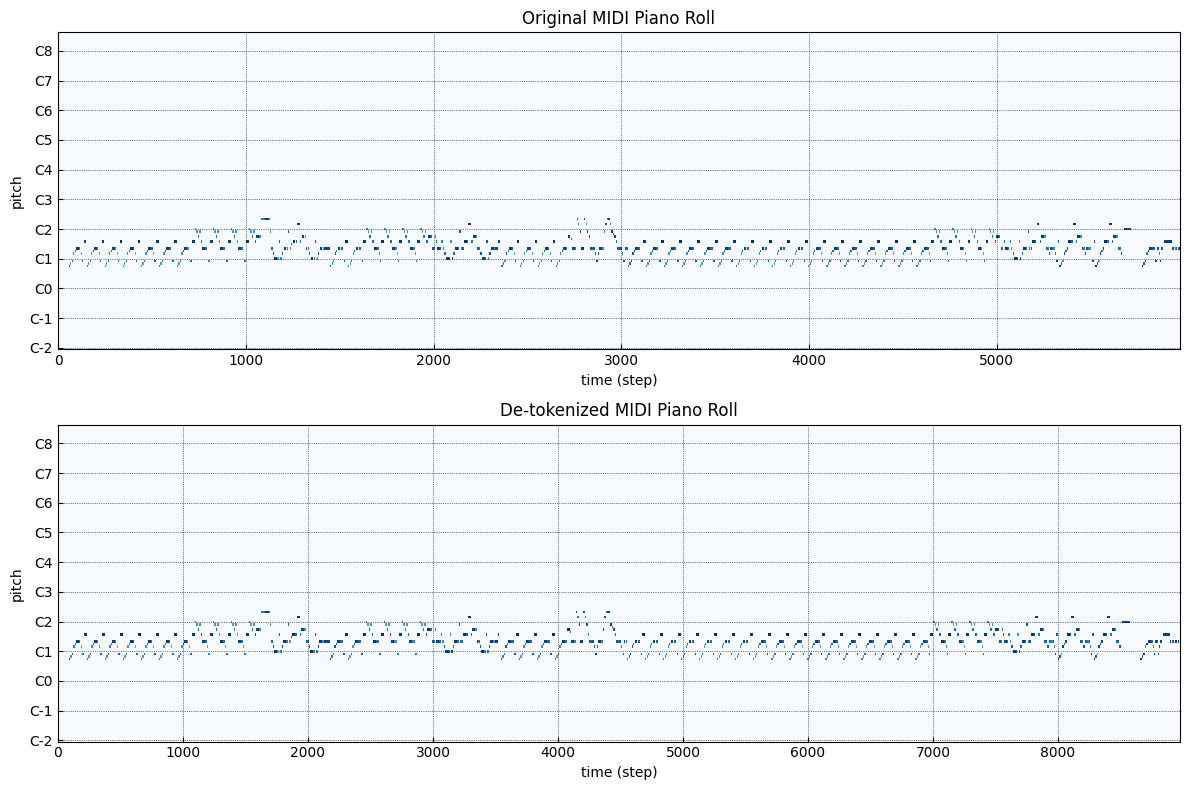

In [28]:
# plot the original and de-tokenized MIDI piano rolls

# original MIDI
pianoroll_data_orig = pypianoroll.read(midi_files[1])
# de-tokenized MIDI
pianoroll_data_detok = pypianoroll.read("../data/de_tokenized_remi.mid")
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
# plot original
pypianoroll.plot_track(pianoroll_data_orig.tracks[0], axs[0])
axs[0].set_title("Original MIDI Piano Roll")
# plot de-tokenized
pypianoroll.plot_track(pianoroll_data_detok.tracks[0], axs[1])
axs[1].set_title("De-tokenized MIDI Piano Roll")
plt.tight_layout()
plt.show()

## MusicXML Tokenizers

As a tokenizer for MusicXML files, we will use the `linearize-musicxml` library, which provides a way to linearize MusicXML data into token sequences.

In [29]:
# lineaize a MusicXML file
def linearize(filename: str) -> str:
    with open(filename, "r") as f:
        tree = ET.ElementTree(ET.fromstring(f.read()))

    part = tree.find("part")

    if part is None:
        raise ValueError("No <part> element found.")

    linearizer = Linearizer(errout=sys.stderr)
    linearizer.process_part(part)

    return " ".join(linearizer.output_tokens)


linearized_musicxml = linearize(musicxml_files[0])
print(f"First 100 tokens of linearized MusicXML:\n{linearized_musicxml.split()[:100]}")

First 100 tokens of linearized MusicXML:
['measure', 'key:fifths:0', 'time', 'beats:3', 'beat-type:4', 'clef:G2', 'A4', 'voice:1', 'quarter', 'stem:up', 'E4', 'quarter', 'F4', 'quarter', 'measure', 'E4', 'voice:1', 'half', 'stem:up', 'E4', 'quarter', 'measure', 'A4', 'voice:1', 'quarter', 'stem:up', 'E4', 'quarter', 'F4', 'quarter', 'measure', 'E4', 'voice:1', 'half', 'dot', 'stem:up', 'measure', 'A4', 'voice:1', 'quarter', 'stem:up', 'C5', 'quarter', 'stem:down', 'B4', 'quarter', 'measure', 'A4', 'voice:1', 'quarter', 'stem:up', 'slur:start', 'G4', 'quarter', 'sharp', 'slur:stop', 'E4', 'quarter', 'measure', 'F4', 'voice:1', 'quarter', 'stem:up', 'A4', 'quarter', 'G4', 'eighth', 'dot', 'beam:begin', 'F4', '16th', 'beam:end', 'beam:backward-hook', 'measure', 'F4', 'voice:1', 'quarter', 'stem:up', 'slur:start', 'E4', 'quarter', 'slur:stop', 'rest', 'eighth', 'E4', 'eighth', 'measure', 'A4', 'voice:1', 'quarter', 'stem:up', 'E4', 'quarter', 'G4', 'eighth', 'beam:begin', 'F4', 'eighth', '